In [1]:
import numpy as np
import os
import time
import random
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.nn.init as init
from tqdm import tqdm
from torchsummary import summary
from torchmetrics.classification import MulticlassF1Score
from utils.load_data import ECGDataset, ECGCollate, SmartBatchSampler, load_dataset, load_ecg
from resnet1d import ResNet1D
from utils.plot_utils import plot_lth_progress, plot_layerwise_remaining_params
from utils.save_utils import save_checkpoint, load_checkpoint
from utils.train_utils import train_model, create_tqdm_bar, calculate_priors, weights_init_kaiming
from utils.pruning_utils import Mask, prune, PrunedModel

%load_ext autoreload
%autoreload 2

os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.


In [2]:
def run_lth_ecg(pruning_params, network, train_loader, val_loader, loss_func, device, resume=False) : 
    
    """
    Run the Lottery Ticket Hypothesis (LTH) procedure on an ECG model.

    Iteratively prunes the network, retrains the pruned model, and evaluates F1 score.
    Supports resuming from a checkpoint.

    Args:
        pruning_params (dict): Parameters controlling pruning (p_init, alpha, target_reduction_factor, layers to ignore, etc.).
        network (nn.Module): Initial neural network to prune.
        train_loader (DataLoader): Training data loader.
        val_loader (DataLoader): Validation data loader.
        loss_func (nn.Module): Loss function for training.
        device (torch.device): Device to run training on (CPU or GPU).
        resume (bool, optional): Whether to resume from a checkpoint if it exists. Default is False.

    Returns:
        current_mask (Mask): Final mask after pruning.
        history_theta (list[float]): History of reduction factors at each pruning step.
        history_f1 (list[float]): History of validation F1 scores at each pruning step.
    """
    
    # Initalization 
    checkpoint_file = "checkpoints/lth_ecg_checkpoint.pth"
    
    prior = calculate_priors(train_loader,device,4,500).to(device)

    pruning_percentage = pruning_params["p_init"]
    
    current_mask = Mask.ones_like(network)
    current_mask_np = current_mask.numpy()
    initial_weights_number = np.sum([np.sum(v) for v in current_mask_np.values()])
    
    initial_untrained_model = copy.deepcopy(network)
    
    remaining_weights_number = initial_weights_number
    
    f1_metric = MulticlassF1Score(num_classes=4, average=None).to(device)

    # lists for backup 
    history_theta = []
    history_f1 = []
    history_sparsity = []

    step = 0

    # In case we interrupted the experience and we want to resume it at the step it stopped
    if resume and os.path.exists(checkpoint_file):
        
        checkpoint = load_checkpoint(checkpoint_file)  # Load the checkpoint file
        
        step = checkpoint['step']
        pruning_percentage = checkpoint['pruning_percentage']
        current_mask = checkpoint['current_mask']
        history_theta = checkpoint['history_theta']
        history_f1 = checkpoint['history_f1']
        history_sparsity = checkpoint['history_sparsity']
        remaining_weights_number = sum(v.sum().item() for v in current_mask.values())
        
        # Set the initial weights (before any training)
        initial_untrained_model.load_state_dict(checkpoint['initial_weights'])
        
        # Create the current pruned model
        D = PrunedModel(model=copy.deepcopy(initial_untrained_model), mask=current_mask).to(device)
        
        print(f"Resume at step {step}")   

    else:
        D = copy.deepcopy(network)
    
    while (initial_weights_number/remaining_weights_number) < pruning_params["target_reduction_factor"]:
        
        pruning_fraction = pruning_percentage/100
        
        print(f"\n{'='*30} STEP {step} {'='*30}")
        print(f"Remaining_weights_number = {remaining_weights_number:.2e}")
        print("Current reduction factor (theta) = ", np.round(initial_weights_number/remaining_weights_number, 2), ' over 42')
        print("Pruning percentage = ", np.round(pruning_percentage,2), ' %')
        print("Pruning fraction = ", np.round(pruning_fraction,2))
        print("Model sparcity (percentage of weight that has been pruned): ", current_mask.sparsity )  
        
        # Train the DL network with the given data
        D,final_f1, f1_through_training = train_model(D, train_loader, val_loader, loss_func, device, prior = prior, epochs=20)

        # Backup
        history_theta.append(initial_weights_number/remaining_weights_number)
        history_sparsity.append(current_mask.sparsity)
        
        # Avoid nested PrunedModel
        if isinstance(D, PrunedModel):
            model_to_prune = D.model
        else:
            model_to_prune = D

        # Prune p_init% of weights which are of least magnitude (Global Pruning)
        new_mask = prune(pruning_fraction, pruning_params["pruning_layers_to_ignore"], model_to_prune, current_mask)
        
        # New sparse model with trained weights 
        D_sparse = PrunedModel(model=model_to_prune,mask = new_mask).to(device)

        # Validation
        D_sparse.eval()
        val_loop = create_tqdm_bar(val_loader, desc=f'Validation Sparse Model [step : {step}]')
        f1_metric.reset() # Reset pour calculer uniquement la val
        
        with torch.no_grad():
            for val_iteration, batch in val_loop:
                ecgs, labels = batch
                ecgs, labels = ecgs.to(device), labels.to(device)

                pred = D_sparse(ecgs)
                
                # Compute mean f1 score
                probs = F.softmax(pred, dim=1).transpose(1, 2)
                adjusted_probs = probs / prior
                indices = torch.argmax(adjusted_probs, dim=2)
                final_preds, _ = torch.mode(indices, dim=1)
                final_labels = labels[:, 0] if labels.dim() > 1 else labels
                f1_metric.update(final_preds, final_labels)

                current_val_f1s = f1_metric.compute()
                current_val_cinc = torch.mean(current_val_f1s[:3]).item()
                
                # Update the progress bar.
                val_loop.set_postfix(f1_val=f"{current_val_cinc:.4f}")
        
        # Backup f1 score
        history_f1.append(current_val_cinc)

        # Plot figures and save them every 5 steps 
        if step % 5 == 0:
            plot_lth_progress(history_theta, history_f1, 'plots/lth_ecg/')
            plot_layerwise_remaining_params(D_sparse, current_mask, 'plots/lth_ecg/')

        # Update pruning percentage (alpha = 1.1)
        pruning_percentage = pruning_percentage**(1/pruning_params['alpha'])

        # reset unpruned weights to their initial random values and D = D_sparse
        D = PrunedModel(model=copy.deepcopy(initial_untrained_model), mask=new_mask).to(device)
        
        remaining_weights_number = sum(v.sum().item() for v in new_mask.values())
       
        current_mask = new_mask
       
        step+=1

        # Backup the experience from current step in a checkpoint file
        checkpoint_state = {
            'step': step,
            'pruning_percentage': pruning_percentage,
            'current_mask': current_mask,
            'initial_weights': initial_untrained_model.state_dict(),
            'reduction_factor': initial_weights_number / remaining_weights_number,
            'history_theta': history_theta,
            'history_f1': history_f1,
            'history_sparsity': history_sparsity,
            'f1_through_training' : f1_through_training,
            'layerwise_sparcity': current_mask.layerwise_sparsity(),
            'layerwise_remaining_params': current_mask.layerwise_remaining_params()
        }
        save_checkpoint(checkpoint_state, filename=checkpoint_file)
        
        print("="*60, "\n")
        
    # Final plot
    plot_lth_progress(history_theta, history_f1, save_dir = 'plots/lth_ecg/')

    return current_mask, history_theta, history_f1

In [3]:
print("Loading training set...")
train = load_dataset("train.json",256) # 256 like in Hannun et al. 
train_ecgs, train_labels = train

print("Loading dev set...")
val_ecgs,val_labels = load_dataset("dev.json",256)


train_dataset = ECGDataset(train_ecgs, train_labels)
val_dataset = ECGDataset(val_ecgs, val_labels)

# Instanciation du Sampler intelligent
train_batch_sampler = SmartBatchSampler(train_dataset, 32)
val_batch_sampler = SmartBatchSampler(val_dataset, 32)

train_collate_fn = ECGCollate(
    pad_val_x=train_dataset.pad_value_x_normalized,
    num_classes=train_dataset.num_classes
    )

val_collate_fn = ECGCollate(
    pad_val_x=val_dataset.pad_value_x_normalized,
    num_classes=val_dataset.num_classes
    )

train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_batch_sampler, 
    collate_fn=train_collate_fn,
    num_workers=4
    )

val_loader = DataLoader(
    val_dataset,
    batch_sampler=val_batch_sampler, 
    collate_fn=val_collate_fn,
    num_workers=4
    )


Loading training set...


100%|██████████| 7676/7676 [00:01<00:00, 4361.32it/s]


Loading dev set...


100%|██████████| 852/852 [00:00<00:00, 5395.38it/s]


MEAN :  7.4661856  STD :  236.10312
self.classes :  ['A', 'N', 'O', '~']
self.class_to_int :  {'A': 0, 'N': 1, 'O': 2, '~': 3}
MEAN :  8.029898  STD :  242.35907
self.classes :  ['A', 'N', 'O', '~']
self.class_to_int :  {'A': 0, 'N': 1, 'O': 2, '~': 3}
Sorting dataset by length to minimize padding...
Sorting dataset by length to minimize padding...


In [4]:
# Hyperparameters setting :
hparams = {
    "in_channels" : 1,  # Single lead ECG signals 
    "base_filters" : 32,  # 2 in Hannun et al.
    "kernel_size" : 16, 
    "stride" : 2, 
    "groups" : 1,  # to make a classic ResNet architecture
    "n_block" : 16,  # 16 in Hannun et al.
    "n_classes" : 4,  # Imposed by the Physionet 2017 dataset
    "downsample_gap" : 2, # every 2 block like in Hannun et al. 
    "increasefilter_gap" : 4,  # kernel_size doubles every 4 blocks
    "use_bn" : True,  # Use Batch Normalization layers
    "use_do" : True  # Use Dropout layers 
    } 

# Get GPU if available 
device_str = "cuda"
device = torch.device(device_str if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

# Instantiate SOTA model for ECG Classification
model = ResNet1D(**hparams).to(device)

# Apply Kainming He Normal Initialization like specified in the article by Hannun et al.
model.apply(weights_init_kaiming)
print("Kaiming He Initialisation applied ! ")


Running on cuda
Kaiming He Initialisation applied ! 


In [5]:
# Outputs the SOTA model full architecture, number of params and size in MB
summary(model, (1,100), device=device_str)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 100]             544
   MyConv1dPadSame-2              [-1, 32, 100]               0
       BatchNorm1d-3              [-1, 32, 100]              64
              ReLU-4              [-1, 32, 100]               0
            Conv1d-5              [-1, 32, 100]          16,416
   MyConv1dPadSame-6              [-1, 32, 100]               0
       BatchNorm1d-7              [-1, 32, 100]              64
              ReLU-8              [-1, 32, 100]               0
           Dropout-9              [-1, 32, 100]               0
           Conv1d-10              [-1, 32, 100]          16,416
  MyConv1dPadSame-11              [-1, 32, 100]               0
       BasicBlock-12              [-1, 32, 100]               0
      BatchNorm1d-13              [-1, 32, 100]              64
             ReLU-14              [-1, 

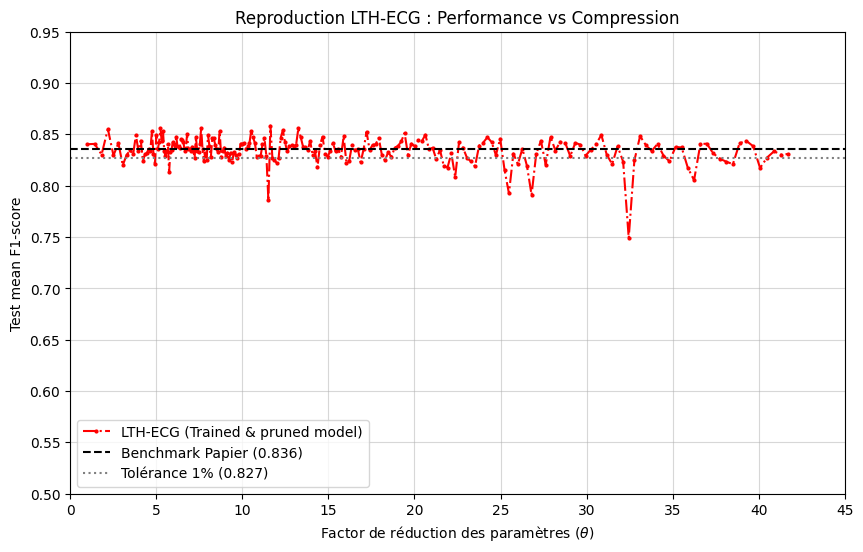

Graphique mis à jour et sauvegardé dans : plots/lth_ecg/lth_performance_plot.png


In [6]:
# The loss function we use for classification.
loss_func = nn.CrossEntropyLoss() 

pruning_params = {
                  "p_init" : 30, # like in Sahu et al. 2022
                  "target_reduction_factor" : 42, # to reach a 1 MB model size
                  "alpha" : 1.1, # like in Sahu et al. 2022
                  "pruning_layers_to_ignore" : None
                  }


# Run the LTH-ECG Pruning Algorithm from Sahu et al. (2022) to find a Winning Ticket
final_mask, history_theta, history_f1 = run_lth_ecg(pruning_params, model, train_loader, val_loader, loss_func, device, resume=True) 